In [1]:
from datetime import datetime as dt
from scipy import signal
import pandas as pd
import numpy as np
import xarray as xr
from siphon.catalog import TDSCatalog, Dataset
import pandas.tseries.offsets as offsets
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import savgol_filter, find_peaks
from scipy.optimize import curve_fit
import seaborn as sns
import scipy as sp
import time
import datetime
from tqdm.notebook import tqdm
from rasterio.plot import show
from distributed import Client, LocalCluster

### Create helper functions (will eventually be pip-installable)

In [2]:
def non_uniform_savgol(x, y, window, polynom):
    """
  Applies a Savitzky-Golay filter to y with non-uniform spacing
  as defined in x

  This is based on https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data
  The borders are interpolated like scipy.signal.savgol_filter would do

  Parameters
  ----------
  x : array_like
      List of floats representing the x values of the data
  y : array_like
      List of floats representing the y values. Must have same length
      as x
  window : int (odd)
      Window length of datapoints. Must be odd and smaller than x
  polynom : int
      The order of polynom used. Must be smaller than the window size

  Returns
  -------
  np.array of float
      The smoothed y values
  """
    if len(x) != len(y):
        raise ValueError('"x" and "y" must be of the same size')

    if len(x) < window:
        raise ValueError('The data size must be larger than the window size')

    if type(window) is not int:
        raise TypeError('"window" must be an integer')

    if window % 2 == 0:
        raise ValueError('The "window" must be an odd integer')

    if type(polynom) is not int:
        raise TypeError('"polynom" must be an integer')

    if polynom >= window:
        raise ValueError('"polynom" must be less than "window"')

    half_window = window // 2
    polynom += 1

    # Initialize variables
    A = np.empty((window, polynom))  # Matrix
    tA = np.empty((polynom, window))  # Transposed matrix
    t = np.empty(window)  # Local x variables
    y_smoothed = np.full(len(y), np.nan)

    # Start smoothing
    for i in range(half_window, len(x) - half_window, 1):
        # Center a window of x values on x[i]
        for j in range(0, window, 1):
            t[j] = x[i + j - half_window] - x[i]

        # Create the initial matrix A and its transposed form tA
        for j in range(0, window, 1):
            r = 1.0
            for k in range(0, polynom, 1):
                A[j, k] = r
                tA[k, j] = r
                r *= t[j]

        # Multiply the two matrices
        tAA = np.matmul(tA, A)

        # Invert the product of the matrices
        tAA = np.linalg.inv(tAA)

        # Calculate the pseudoinverse of the design matrix
        coeffs = np.matmul(tAA, tA)

        # Calculate c0 which is also the y value for y[i]
        y_smoothed[i] = 0
        for j in range(0, window, 1):
            y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]

        # If at the end or beginning, store all coefficients for the polynom
        if i == half_window:
            first_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    first_coeffs[k] += coeffs[k, j] * y[j]
        elif i == len(x) - half_window - 1:
            last_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]

    # Interpolate the result at the left border
    for i in range(0, half_window, 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += first_coeffs[j] * x_i
            x_i *= x[i] - x[half_window]

    # Interpolate the result at the right border
    for i in range(len(x) - half_window, len(x), 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += last_coeffs[j] * x_i
            x_i *= x[i] - x[-half_window - 1]

    return y_smoothed

def savgol_ndvi(timeseries, non_uniform=False, xdate=None, wnds=[11, 7],
                orders=[3, 3], limit=None, lwr=False, debug=False):
    # https://gis.stackexchange.com/questions/173721/reconstructing-modis-time-series-applying-savitzky-golay-filter-with-python-nump/173747
    interp_ts = pd.Series(timeseries)
    interp_ts = interp_ts.interpolate(method='linear', limit=limit)
    smooth_ts = interp_ts
    wnd, order = wnds[0], orders[0]
    F = 1e8
    W = None
    it = 0
    while True:
        if non_uniform:
            smoother_ts = non_uniform_savgol(xdate, smooth_ts, 
                                             window=wnd, polynom=order)
        else:
            smoother_ts = savgol_filter(smooth_ts, window_length=wnd, polyorder=order)
        diff = smoother_ts - interp_ts
        if lwr:
            sign = diff < 0
        else:
            sign = diff > 0
        if W is None:
            W = 1 - np.abs(diff) / np.max(np.abs(diff)) * sign
            wnd, order = wnds[1], orders[1]
        fitting_score = np.sum(np.abs(diff) * W)
        #print(it, ' : ', fitting_score)
        if fitting_score > F:
            break
        else:
            F = fitting_score
            it += 1
        if it > 100:
            break
        smooth_ts = smoother_ts * sign + interp_ts * (1 - sign)
    if debug:
        return smooth_ts, interp_ts
    return smooth_ts


def apply_savgol(ts, window=31, polynom=3, limit=None):
    ts_tmp = ts.copy()
    ts_interp = pd.Series(ts_tmp)
    ts_interp = ts_interp.interpolate(method='linear', limit_area='inside', limit=limit)
    ts_interp = ts_interp.interpolate(method='linear', limit=None, limit_direction='both',
                                      limit_area='outside')
    try:
        ts_smooth = savgol_filter(ts_interp, window_length=window, polyorder=polynom)
    except np.linalg.LinAlgError:
        ts_smooth = ts_interp
    return ts_smooth


def modified_z_score(ts):
    # see https://towardsdatascience.com/removing-spikes-from-raman-spectra-8a9fdda0ac22
    median_int = np.nanmedian(ts)
    mad_int = np.nanmedian([np.abs(ts - median_int)])
    modified_z_scores = 0.6745 * (ts - median_int) / mad_int
    return modified_z_scores


def mask_ts_outliers(ts, threshold=3.5):
    # see https://towardsdatascience.com/removing-spikes-from-raman-spectra-8a9fdda0ac22
    ts_masked = ts.copy()
    ts_modz_robust = np.array(abs(modified_z_score(ts_masked)))
    if not np.all(np.isnan(ts_modz_robust)):
        spikes1 = ts_modz_robust > threshold
        ts_masked[spikes1] = np.nan
    return ts_masked


def despike_ts(dat_ts, dat_thresh, days_thresh, z_thresh=3.5, mask_outliers=False, iters=2):
    dat_ts_cln = dat_ts.copy()
    if mask_outliers:
        dat_ts_cln = mask_ts_outliers(dat_ts_cln, threshold=z_thresh)
    dat_mask = np.zeros_like(dat_ts_cln)
    for i in range(iters):
        for idx in range(len(dat_ts_cln)):
            if not np.isnan(dat_ts_cln[idx]):
                idx_clear = np.where(~np.isnan(dat_ts_cln))[0]
                if idx == np.min(idx_clear):
                    continue
                elif idx == np.max(idx_clear):
                    continue
                else:
                    idx_pre = idx_clear[idx_clear < idx][-1]
                    idx_post = idx_clear[idx_clear > idx][0]
                    y = np.array([dat_ts_cln[idx_pre], dat_ts_cln[idx_post]])
                    x = np.array([idx_pre, idx_post])
                    dx = np.diff(x)
                    dy = np.diff(y)
                    slope = dy / dx
                    dat_interp = dat_ts_cln[idx_pre] + slope[0] * (idx - idx_pre)
                    dat_diff = dat_interp - dat_ts_cln[idx]
                    shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
                    if (idx_post - idx_pre < days_thresh) & (np.abs(dat_diff) > dat_thresh) & (np.abs(shadow_val) > 2):
                        dat_ts_cln[idx] = np.nan
                        dat_mask[idx] = 1
                    else:
                        continue
            else:
                continue
    dat_ts_cln[dat_mask == 1] = np.nan
    return dat_ts_cln

def double_logistic(x, vmin, vmax, sos, scaleS, eos, scaleA):
    y = vmin + vmax * ((1 / (1 + np.exp(-scaleS * (x - sos)))) + (1 / (1 + np.exp(scaleA * (x - eos)))) - 1)
    return y

def apply_dl(dat_ts, maxiter=10000, tol=0.1):
    ndvi_smooth = pd.Series(dat_ts)
    try:
        p0 = [ndvi_smooth.quantile(q=0.01),
              np.max(ndvi_smooth),
              int(np.percentile(ndvi_smooth.index, 25)),
              1.0,
              int(np.percentile(ndvi_smooth.index, 75)),
              1.0]  # this is a mandatory initial guess
        popt, pcov = curve_fit(double_logistic, ndvi_smooth.index, ndvi_smooth,
                               p0, method='lm', maxfev=20000, ftol=tol, xtol=tol)
        ndvi_dl = double_logistic(ndvi_smooth.index, *popt)
    except RuntimeError:
        try:
            p0 = [ndvi_smooth.quantile(q=0.01),
                  np.max(ndvi_smooth),
                  120,
                  1.0,
                  265,
                  1.0]  # this is a mandatory initial guess
            popt, pcov = curve_fit(double_logistic, ndvi_smooth.index, ndvi_smooth,
                                   p0, method='lm', maxfev=maxiter, ftol=tol, xtol=tol)
            ndvi_dl = double_logistic(ndvi_smooth.index, *popt)
        except RuntimeError:
            ndvi_dl = ndvi_smooth * np.nan
            print(RuntimeError)
    return ndvi_dl

def savgol_ndvi_xr(dat, dims, kwargs={}):
    xr_smoothed = xr.apply_ufunc(savgol_ndvi,
                                 dat,
                                 kwargs=kwargs,
                                 input_core_dims=[dims],
                                 output_core_dims=[dims],
                                 dask='parallelized', vectorize=True,
                                 output_dtypes=[float])
    return xr_smoothed

def apply_savgol_xr(dat, dims, kwargs={}):
    xr_smoothed = xr.apply_ufunc(apply_savgol,
                                 dat,
                                 kwargs=kwargs,
                                 input_core_dims=[dims],
                                 output_core_dims=[dims],
                                 dask='parallelized', vectorize=True,
                                 output_dtypes=[float])
    return xr_smoothed


def despike_ts_xr(dat, dat_thresh, dims, days_thresh=60, z_thresh=3.5, mask_outliers=False, iters=2):
    xr_ds = xr.apply_ufunc(despike_ts,
                           dat,
                           kwargs=dict(dat_thresh=dat_thresh,
                                       days_thresh=days_thresh,
                                       z_thresh=z_thresh,
                                       mask_outliers=mask_outliers,
                                       iters=iters),
                           input_core_dims=[dims],
                           output_core_dims=[dims],
                           dask='parallelized', vectorize=True,
                           output_dtypes=[float])
    return xr_ds

def apply_dl_xr(dat, dims, kwargs={}):
    xr_dl = xr.apply_ufunc(apply_dl,
                                 dat,
                                 kwargs=kwargs,
                                 input_core_dims=[dims],
                                 output_core_dims=[dims],
                                 dask='parallelized', vectorize=True,
                                 output_dtypes=[float])
    return xr_dl

def mask_avhrr_xr(src):
    band_QA = src.astype('int16')

    def unpack_bits(b_num):
        mask = np.subtract(np.divide(band_QA, 2 ** b_num).astype('int'),
                           (np.divide(np.divide(band_QA, 2 ** b_num).astype('int'), 2).astype('int') * 2))
        return mask

    def mask_from_QA(dat, bits):
        return xr.apply_ufunc(unpack_bits, bits).astype('int8')

    cloud_mask = mask_from_QA(band_QA, 1)
    cloud_shadow_mask = mask_from_QA(band_QA, 2)
    water_mask = mask_from_QA(band_QA, 3)
    glint_mask = mask_from_QA(band_QA, 4)
    night_mask = mask_from_QA(band_QA, 6)
    channel_mask = ~(mask_from_QA(band_QA, 7).astype(bool)).astype(int)
    rho_mask = mask_from_QA(band_QA, 13)
    
    all_masks = xr.concat([cloud_mask, cloud_shadow_mask,
                           water_mask, glint_mask, night_mask,
                           channel_mask, rho_mask],
                          dim='time')
    QA_mask_all = all_masks.groupby('time').max()
    return QA_mask_all

def calc_dl(dat_ts, xdate=None, 
            wnds=[21, 13], limit=None, dat_thresh=0.07, days_thresh=30, window=31, polynom=3):
    if xdate is None:
        xdate=np.arange(len(dat_ts))
    ts_sm1 = savgol_ndvi(dat_ts, 
                        xdate=xdate,
                        wnds=wnds,
                        limit=limit)
    ts_ds = despike_ts(ts_sm1,
                       dat_thresh=dat_thresh,
                       days_thresh=days_thresh)
    ts_sm2 = apply_savgol(ts_ds, window=window, polynom=polynom)
    ts_dl = apply_dl(ts_sm2)
    return ts_dl

def calc_dl_xr(dat, dims, kwargs=None):
    xr_dl = xr.apply_ufunc(calc_dl,
                             dat,
                             kwargs=kwargs,
                             input_core_dims=[dims],
                             output_core_dims=[dims],
                             dask='parallelized', vectorize=True,
                             output_dtypes=[float])
    return xr_dl


### Define cluster for distributed processing

In [3]:
cluster_loc = 'coiled'

if cluster_loc == 'local':
    clust = LocalCluster(n_workers=8, threads_per_worker=2)
    client = Client(clust)
elif cluster_loc == 'coiled':
    import coiled
    coiled.create_software_environment(
    name="py_geo",
    conda="py_geo_environment.yaml")
    clust = coiled.Cluster(
        name="avhrr_cog_coiled",
        software="py_geo",
        n_workers=48, # 200 and then 1 with worker_cpu=128 USE SPOT
        worker_cpu=2,
        backend_options={"spot": True})
    client = Client(clust)
elif cluster_loc == 'hpc':
    import dask_jobqueue as jq
    import dask
    dask.config.set({'distributed.dashboard.link': '/user/{USER}/proxy/{port}/status'})
    partition='brief-low'#,debug,mem,mem-low'
    num_processes = 12
    num_threads_per_processes = 2
    mem = 0.8*num_processes*num_threads_per_processes#*1.25
    n_cores_per_job = num_processes*num_threads_per_processes
    clust = jq.SLURMCluster(queue=partition,
                            processes=num_processes,
                            cores=n_cores_per_job,
                            memory=str(mem)+'GB',
                            interface='ib0',
                            local_directory='$TMPDIR',
                            death_timeout=30,
                            walltime='02:00:00',
                            job_extra=["--output=/dev/null","--error=/dev/null"])
    client=Client(clust)

display(client)

Found existing software environment build, returning


Output()

Found software environment build
Created fw rule: inbound [8786-8787] [0.0.0.0/0] []
Created FW rules: coiled-dask-kearney58-103372-firewall
Created fw rule: cluster [0-65535] [None] [coiled-dask-kearney58-103372-firewall -> coiled-dask-kearney58-103372-firewall]
Created FW rules: coiled-dask-kearney58-103372-cluster-firewall
Created fw rule: cluster [0-65535] [None] [coiled-dask-kearney58-103372-cluster-firewall -> coiled-dask-kearney58-103372-cluster-firewall]
Created scheduler VM: coiled-dask-kearney58-103372-scheduler (type: t3a.medium, ip: ['52.88.182.179'])


<Client: 'tls://10.6.8.105:8786' processes=6 threads=12, memory=45.36 GiB>

### Lazy-load data and define parameters

In [4]:
# point to the THREDDS server
server_url = 'https://www.ncei.noaa.gov/thredds/'

# open the aggregated NDVI dataset without decoding times
avhrr = xr.open_dataset(server_url + 'dodsC/cdr/ndvi/NDVI-Aggregation.ncml', decode_times=False)

# convert time to datetime and resolve error related to very high timestamp value
if avhrr.time.max() > avhrr.time[-1]:
    avhrr = xr.decode_cf(avhrr.drop_sel(time=avhrr.time.max()))
else:
    avhrr = xr.decode_cf(avhrr)

In [5]:
# define lower left corner
min_y, min_x = 45.25, -110.00

# define upper right corner
max_y, max_x = 36.00, -100.00

# define start and end years
start_yr, end_yr = 1982, 2020

# define chunk sizes
chunk_dict = {'time': -1,
              'longitude': 1,
              'latitude': 1}

### Loop through years and mask and smooth NDVI for defined region

In [7]:
# loop through years and print steps
from dask.distributed import performance_report
prefix = 'coiled_48_'
for yr in tqdm(range(start_yr, end_yr)):
    t0=time.time()
    print(yr)
    print('...loading data')
    avhrr_sub = avhrr.sel(time=slice(str(yr) + "-01-01", str(yr) + "-12-31"),
                          latitude=slice(min_y, max_y), 
                          longitude=slice(min_x, max_x)).drop_vars(['crs', 'lat_bnds', 'lon_bnds']).load()
    t1=time.time()
    print('......data loaded in ' + str(round(t1-t0, 2)) + ' secs')
    with performance_report('PR_' + prefix + 'all_steps.html'):
        print('...masking')
        avhrr_sub['MASK'] = mask_avhrr_xr(avhrr_sub.QA)
        avhrr_sub = avhrr_sub.where(avhrr_sub.MASK == 1).compute()
        print('...running initial NDVI smooth')
        avhrr_sub['NDVI_smth1'] = savgol_ndvi_xr(avhrr_sub['NDVI'].chunk(chunk_dict), dims=['time'], 
                                                 kwargs={'xdate': avhrr_sub.time.dt.dayofyear, 
                                                         'wnds': [21, 13],
                                                         'limit': None}).compute()
        print('...despiking')
        avhrr_sub['NDVI_smth1_ds'] = despike_ts_xr(avhrr_sub['NDVI_smth1'].chunk(chunk_dict),
                                                   dat_thresh=0.07,
                                                   days_thresh=30,
                                                   dims=['time']).compute()
        print('...smoothing')
        avhrr_sub['NDVI_smth2'] = apply_savgol_xr(avhrr_sub['NDVI_smth1_ds'].chunk(chunk_dict),
                                                  dims=['time'], 
                                                  kwargs={'window': 61, 
                                                          'polynom': 3,
                                                          'limit': None}).compute()
        print('...fitting double-logistic curve')
        avhrr_sub['NDVI_smth2_dl'] = apply_dl_xr(avhrr_sub['NDVI_smth2'].chunk(chunk_dict),
                                                 dims=['time'], kwargs={'maxiter': 1000, 'tol': 0.0001}).compute()
    print('...converting to dataframe')
    df_tmp = avhrr_sub.to_dataframe().reset_index(drop=False)
    print('...saving to disk\n')
    df_tmp.to_csv('AVHRR_NDVI_timeseries_' + str(yr) + '.csv', index=False)
    t2=time.time()
    print('......processing completed in ' + str(round(t2-t1, 2)) + ' secs\n')

  0%|          | 0/38 [00:00<?, ?it/s]

1982
...loading data
......data loaded in 889.5 secs
...masking
...running initial NDVI smooth


distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


CommClosedError: ConnectionPool not running. Status: Status.closed

distributed.deploy.cluster - WARNING - Failed to sync cluster info multiple times - perhaps there's a connection issue? Error:
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/asyncio/tasks.py", line 492, in wait_for
    fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-package

# TESTING

In [6]:
# define upper left corner
max_y, min_x = 42.00, -107.00

# define lower right corner
min_y, max_x = 40.00, -105.00

# define start and end years
start_date, end_date = "1982-01-01", "1982-12-31"

# define chunk sizes
chunk_dict = {'time': -1,
              'longitude': 1,
              'latitude': 1}

In [7]:
%%time
# check how long it takes to performance_reportta for a specified time range and area
avhrr_sub = avhrr.sel(time=slice(start_date, end_date),
                      latitude=slice(max_y, min_y), 
                      longitude=slice(min_x, max_x)).drop_vars(['crs', 'lat_bnds', 'lon_bnds']).load()

CPU times: user 5.16 s, sys: 1.42 s, total: 6.58 s
Wall time: 2min 18s


In [110]:
%%time
# check how long to mask data
print('...masking')
#avhrr_sub = avhrr_sub.chunk(chunk_dict)  # try with chunking
avhrr_sub['MASK'] = mask_avhrr_xr(avhrr_sub.QA)
avhrr_sub2 = avhrr_sub.where(avhrr_sub.MASK == 1).compute()

...masking
CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 109 ms


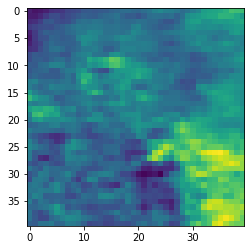

<AxesSubplot:>

In [111]:
# display mean NDVI across time as sanity check
show(avhrr_sub2['NDVI'].mean(dim='time'))

In [112]:
%%time
from dask.distributed import performance_report
prefix = 'local_16_'
x_doy = avhrr_sub2['time'].dt.dayofyear.values
with performance_report(prefix + 'smooth1.html'):
    # check time to run through each step sequentially
    avhrr_sub2 = avhrr_sub2.isel(longitude=slice(30, 36), latitude=slice(0, 6)).chunk(chunk_dict)
    print('running initial smooth...')
    avhrr_sub2['NDVI_smth1'] = savgol_ndvi_xr(avhrr_sub2['NDVI'],
                           dims=['time'],
                          kwargs={'non_uniform': True, 'xdate': x_doy}).compute()
with performance_report(prefix + 'despike.html'):
    print('despiking...')
    avhrr_sub2['NDVI_smth1_ds'] = despike_ts_xr(avhrr_sub2['NDVI_smth1'].chunk(chunk_dict), 
                          dat_thresh=0.07, days_thresh=30, dims=['time']).compute()
with performance_report(prefix + 'smooth2.html'):
    print('running secondary smooth...')
    avhrr_sub2['NDVI_smth2'] = apply_savgol_xr(avhrr_sub2['NDVI_smth1_ds'].chunk(chunk_dict),
                            dims=['time'], kwargs={'window': 61}).compute()
with performance_report(prefix + 'curve_fit.html'):
    print('fitting double-logistic regression...')
    avhrr_sub2['NDVI_dl'] = apply_dl_xr(avhrr_sub2['NDVI_smth2'].chunk(chunk_dict),
                        dims=['time'], kwargs={'maxiter': 1000, 'tol': 0.0001}).compute()
    #print('converting to dataframe...')
    #df_tmp = avhrr_sub2.to_dataframe().reset_index(drop=False)

running initial smooth...
despiking...


/tmp/ipykernel_98/1237612138.py:204: RuntimeWarning: divide by zero encountered in double_scalars
/tmp/ipykernel_98/1237612138.py:204: RuntimeWarning: invalid value encountered in double_scalars


running secondary smooth...
fitting double-logistic regression...


/tmp/ipykernel_98/1237612138.py:216: RuntimeWarning: overflow encountered in exp


CPU times: user 1.99 s, sys: 120 ms, total: 2.11 s
Wall time: 6.22 s


In [108]:
%%time
avhrr_sub2['NDVI_dl'] = apply_dl_xr(avhrr_sub2['NDVI_smth2'].chunk(chunk_dict),
                        dims=['time'], kwargs={'maxiter': 1000, 'tol': 0.0001}).compute()
df_tmp = avhrr_sub2.to_dataframe().reset_index(drop=False)

/tmp/ipykernel_98/1237612138.py:216: RuntimeWarning: overflow encountered in exp


CPU times: user 449 ms, sys: 84.1 ms, total: 533 ms
Wall time: 4.94 s


<AxesSubplot:xlabel='time'>

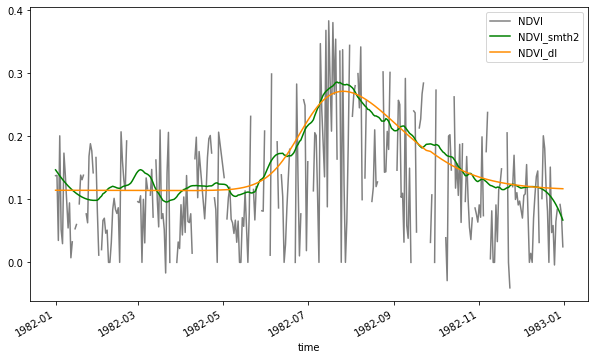

In [119]:
# plot data for single pixel as sanity check
test = df_tmp[(df_tmp.latitude == df_tmp.latitude.unique()[0]) & (df_tmp.longitude == df_tmp.longitude.unique()[5])]
ax = test.plot(y='NDVI', x='time', c='grey', figsize=(10, 6))
test.plot(y='NDVI_smth2', x='time', ax=ax, c='green')
test.plot(y='NDVI_dl', x='time', ax=ax, c='darkorange')


In [84]:
from scipy.signal import find_peaks
peaks = find_peaks(test['NDVI_smth2'], height=0.1, distance=30, prominence=0.05, width=30, rel_height=0.85)

In [85]:
peaks

(array([ 62, 194]),
 {'peak_heights': array([0.15073355, 0.23060519]),
  'prominences': array([0.05300829, 0.14072231]),
  'left_bases': array([0, 0]),
  'right_bases': array([121, 356]),
  'widths': array([109.46836578, 216.52465099]),
  'width_heights': array([0.1056765 , 0.11099123]),
  'left_ips': array([  4.07963694, 128.0045773 ]),
  'right_ips': array([113.54800273, 344.52922829])})

In [31]:
# 3x3 = 2 secs
# 6x6 = 19 secs
# 12x12 = 39secs
# 24x24 = 1.42
avhrr_sub2.nbytes()

<xarray.Dataset>
Dimensions:    (time: 357, latitude: 185, longitude: 200)
Coordinates:
  * latitude   (latitude) float32 45.22 45.17 45.12 45.07 ... 36.12 36.07 36.02
  * longitude  (longitude) float32 -110.0 -109.9 -109.9 ... -100.1 -100.1 -100.0
  * time       (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-12-31
Data variables:
    NDVI       (time, latitude, longitude) float32 0.1153 0.0357 ... 0.0959
    TIMEOFDAY  (time, latitude, longitude) datetime64[ns] 2019-12-30T21:00:00...
    QA         (time, latitude, longitude) float64 2.471e+04 ... 1.651e+04
    MASK       (time, latitude, longitude) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
Attributes: (12/54)
    title:                                  Normalized Difference Vegetation ...
    institution:                            NASA/GSFC/SED/ESD/HBSL/TIS/MODIS-...
    Conventions:                            CF-1.6, ACDD-1.3
    standard_name_vocabulary:               CF Standard Name Table (v25, 05 J...
    naming_authority:                       gov.noaa.ncei
    license:                                See the Use Agreement for this CD...
    ...                                     ...
    LocalGranuleId:                         AVHRR-Land_v005_AVH13C1_NOAA-19_2...
    id:                                     AVHRR-Land_v005_AVH13C1_NOAA-19_2...
    product_version:                        v5r0
    summary:                                AVHRR GAC data from NOAA-19 for 2...
    history:                                Final file replaces preliminary f...
    date_modified:                          2020-01-09T11:20:20Z

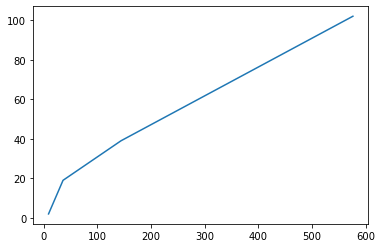

In [21]:
plt.plot([3*3, 6*6, 12*12, 24*24],
         [2, 19, 39, 102])

In [11]:
# cost to run all 40 years at $7.00/hr
102/(24*24)*(185*200)/60/60#*7.00*40

# WHAT AFFECTS COST PER HOUR?
# CAN I MAKE A CLUSTER WITH MANY SMALL WORKERS?

1.8200231481481484

In [30]:
# check how long it takes to run the combined function
%%time
test = calc_dl_xr(avhrr_sub2['NDVI'].isel(longitude=slice(0, 8), 
                                          latitude=slice(0, 2)),
                                  dims=['time'],
                                  kwargs={'xdate': avhrr_sub2['time'].dt.dayofyear.values,
                                          'wnds': [21, 13],
                                          'limit': None,
                                          'dat_thresh': 0.07,
                                          'days_thresh': 30,
                                          'window': 31, 
                                          'polynom': 3}).compute()

CPU times: user 20.7 s, sys: 9.66 s, total: 30.4 s
Wall time: 18.9 s


In [13]:
for yr in tqdm(range(1982, 2020)):
    print(yr)
    print('...loading data')
    avhrr_sub = avhrr.sel(time=slice(str(yr) + "-01-01", str(yr) + "-12-31"),
                          latitude=slice(min_y, max_y), 
                          longitude=slice(min_x, max_x)).drop_vars(['crs', 'lat_bnds', 'lon_bnds']).load()
    print('...masking')
    avhrr_sub['MASK'] = mask_avhrr_xr(avhrr_sub.QA)#.compute()
    avhrr_sub = avhrr_sub.where(avhrr_sub.MASK == 1).chunk(chunk_dict)
    print('...double logistic smoothing')
    avhrr_sub['NDVI_dl'] = calc_dl_xr(avhrr_sub['NDVI'],
                                      dims=['time'],
                                      kwargs={'xdate': avhrr_sub['time'].dt.dayofyear.values,
                                              'wnds': [21, 13],
                                              'limit': None,
                                              'dat_thresh': 0.07,
                                              'days_thresh': 30,
                                              'window': 31, 
                                              'polynom': 3})#.compute()
    #print('...writing to zarr')
    #avhrr_sub.to_zarr('AVHRR_NDVI_timeseries_' + str(yr) + '.zarr', compute=True, mode='w')
    #print('...converting to dataframe')
    #df_tmp = avhrr_sub.to_dataframe().reset_index(drop=False)
    #print('...saving to disk')
    #df_tmp.to_csv('AVHRR_NDVI_timeseries_' + str(yr) + '.csv', index=False)

  0%|          | 0/38 [00:00<?, ?it/s]

1982
...loading data
...masking
...writing to zarr


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

KeyboardInterrupt: 

In [45]:
ts_sm = savgol_ndvi(timeseries=avhrr_sub['NDVI'].isel(latitude=5, longitude=5).values,
                    xdate=avhrr_sub['time'].dt.dayofyear.values,
                    wnds=[31, 15],
                    limit=None)

In [78]:
for i in tqdm(range(len(avhrr_sub.latitude))):
    for j in range(len(avhrr_sub.longitude)):
        print(i, j)
        ts_sm1 = savgol_ndvi(timeseries=avhrr_sub['NDVI'].isel(latitude=i, longitude=j).values,
                    xdate=avhrr_sub['time'].dt.dayofyear.values,
                    wnds=[31, 15],
                    limit=None)
        ts_ds = despike_ts(ts_sm1, dat_thresh=0.07, days_thresh=30)
        ts_sm2 = apply_savgol(ts_ds, window=31, polynom=3)
        ts_dl = apply_dl(ts_sm2)
        #print(ts_sm)

  0%|          | 0/20 [00:00<?, ?it/s]

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15


/tmp/ipykernel_10729/3188173076.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])


0 16


KeyboardInterrupt: 

<AxesSubplot:xlabel='time'>

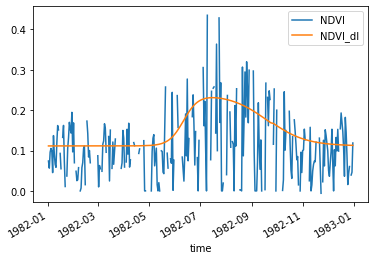

In [95]:
test = df_tmp[(df_tmp.latitude == df_tmp.latitude.unique()[0]) & (df_tmp.longitude == df_tmp.longitude.unique()[0])]
ax = test.plot(y='NDVI', x='time')
test.plot(y='NDVI_dl', x='time', ax=ax)

In [12]:
for yr in tqdm(range(1982, 2020)):
    print(yr)
    print('...loading data')
    avhrr_sub = avhrr.sel(time=slice(str(yr) + "-01-01", str(yr) + "-12-31"),
                          latitude=slice(min_y, max_y), 
                          longitude=slice(min_x, max_x)).drop_vars(['crs', 'lat_bnds', 'lon_bnds']).load()
    avhrr_sub = avhrr_sub.chunk({'time': -1,
                                 'longitude': 2,
                                 'latitude': 2})
    print('...masking')
    avhrr_sub['MASK'] = mask_avhrr_xr(avhrr_sub.QA).compute()
    avhrr_sub = avhrr_sub.where(avhrr_sub.MASK == 1).chunk({'time': -1,
                                 'longitude': 2,
                                 'latitude': 2})
    print('...running initial NDVI smooth')
    avhrr_sub['NDVI_smth1'] = savgol_ndvi_xr(avhrr_sub.NDVI, dims=['time'], 
                                             kwargs={'xdate': avhrr_sub.time.dt.dayofyear, 
                                                     'wnds': [21, 13],
                                                     'limit': None}).compute()
    print('...despiking')
    avhrr_sub['NDVI_smth1_ds'] = despike_ts_xr(avhrr_sub['NDVI_smth1'], dat_thresh=0.07,
                                               days_thresh=30, dims=['time']).compute()
    print('...smoothing')
    avhrr_sub['NDVI_smth2'] = apply_savgol_xr(avhrr_sub['NDVI_smth1_ds'], dims=['time'], 
                                              kwargs={'window': 31, 
                                                      'polynom': 3,
                                                      'limit': None}).compute()
    print('...fitting double-logistic curve')
    avhrr_sub['NDVI_smth2_dl'] = apply_dl_xr(avhrr_sub['NDVI_smth2'], dims=['time']).compute()
    print('...converting to dataframe')
    df_tmp = avhrr_sub.to_dataframe().reset_index(drop=False)
    print('...saving to disk')
    df_tmp.to_csv('AVHRR_NDVI_timeseries_' + str(yr) + '.csv', index=False)

  0%|          | 0/38 [00:00<?, ?it/s]

1982
...loading data
...masking


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-57746' coro=<WebSocketProtocol13.write_message.<locals>.wrapper() done, defined at /home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/tornado/websocket.py:1100> exception=WebSocketClosedError()>
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/tornado/websocket.py", line 1102, in wrapper
    await fut
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/tornado/websocket.py", line 1104, in wrapper
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError


...running initial NDVI smooth
...despiking


/tmp/ipykernel_8429/3213103961.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/tmp/ipykernel_8429/3213103961.py:199: RuntimeWarning: invalid value encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])


...smoothing
...fitting double-logistic curve


/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/distributed/scheduler.py:5622: UserWarning: Scheduler already contains a plugin with name websocket; overwriting.
  warnings.warn(
tornado.application - ERROR - Uncaught exception GET /eventstream (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/eventstream', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/tornado/websocket.py", line 954, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/distributed/http/scheduler/info.py", line 201, in open
    self.plugin.add_worker(self.server, worker)
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/distributed/diagnostics/websocket.py", line 20, in add_worker
    self.socket.sen

<class 'RuntimeError'>


UnboundLocalError: local variable 'ndvi_dl' referenced before assignment

In [25]:
print('...fitting double-logistic curve')
avhrr_sub['NDVI_smth2_dl'] = apply_dl_xr(avhrr_sub['NDVI_smth2'], dims=['time']).compute()

...fitting double-logistic curve


/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/distributed/scheduler.py:5622: UserWarning: Scheduler already contains a plugin with name websocket; overwriting.
  warnings.warn(
tornado.application - ERROR - Uncaught exception GET /eventstream (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/eventstream', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/tornado/websocket.py", line 954, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/distributed/http/scheduler/info.py", line 201, in open
    self.plugin.add_worker(self.server, worker)
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/distributed/diagnostics/websocket.py", line 20, in add_worker
    self.socket.sen

KeyboardInterrupt: 

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-1393287' coro=<WebSocketProtocol13.write_message.<locals>.wrapper() done, defined at /home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/tornado/websocket.py:1100> exception=WebSocketClosedError()>
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/tornado/websocket.py", line 1102, in wrapper
    await fut
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/tornado/websocket.py", line 1104, in wrapper
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError


In [23]:
avhrr_sub.drop_vars(['crs', 'lat_bnds', 'lon_bnds']).nbytes / (1024*1024)

10.352912902832031

In [24]:
#avhrr.nbytes / (1024*1024)

4736305.159654617

In [141]:
avhrr_mask_dict = {
    1: 'cloudy',
    2: 'cloud_shadow',
    3: 'water',
    4: 'sunglint',
    5: 'dense_dark_vegetation',
    6: 'night',
    7: 'ch1_to_5_valid',
    8: 'ch1_invalid',
    9: 'ch2_invalid',
    10: 'ch3_invalid',
    11: 'ch4_invalid',
    12: 'ch5_invalid',
    13: 'rho3_invalid',
    14: 'BRDF_corr_problem',
    15: 'polar_flag'
}

b = 16514
def unpack_bits(b_num):
        mask = np.subtract(np.divide(b, 2 ** b_num).astype('int'),
                           (np.divide(np.divide(b, 2 ** b_num).astype('int'), 2).astype('int') * 2))
        return mask
for i in range(1, 16):
    print(avhrr_mask_dict[i] + ': ' + str(unpack_bits(i)))

cloudy: 1
cloud_shadow: 0
water: 0
sunglint: 0
dense_dark_vegetation: 0
night: 0
ch1_to_5_valid: 1
ch1_invalid: 0
ch2_invalid: 0
ch3_invalid: 0
ch4_invalid: 0
ch5_invalid: 0
rho3_invalid: 0
BRDF_corr_problem: 1
polar_flag: 0


In [ ]:
def get_bit(value, bit_index):
    return value & (1 << bit_index)

get_bit(8000, )

0

In [23]:
avhrr_sub.NDVI.isel(time=20).values

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]], dtype=float32)

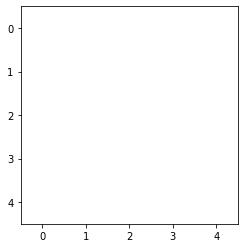

<AxesSubplot:>

In [13]:
avhrr_sub.NDVI.isel(time=20).values
show(avhrr_sub.NDVI.isel(time=140))

In [ ]:
def avhrrMask(image):
    qa = image.select('QA')
    cloudMask = (1 << 0)
    cloudShadowMask = (1 << 2)
    waterMask = (1 << 3)
    glintMask = (1 << 4)
    nightMask = (1 << 6)
    channelMask = (1 << 7)
    rhoMask = (1 << 13)
    brdfMask = (1 << 14)
    maskCloud = qa.bitwiseAnd(cloudMask).eq(0)
    maskCloudShadow = qa.bitwiseAnd(cloudShadowMask).eq(0)
    maskWater = qa.bitwiseAnd(waterMask).eq(0)
    maskGlint = qa.bitwiseAnd(glintMask).eq(0)
    maskNight = qa.bitwiseAnd(nightMask).eq(0)
    maskNDVI = image.gt(0)
    return image.updateMask(maskCloud).updateMask(maskCloudShadow).updateMask(maskWater).updateMask(maskGlint) \
        .updateMask(maskNight).updateMask(maskNDVI) \
        .copyProperties(image, ["system:time_start"])

In [111]:
avhrr_sub['NDVI_smth1'] = savgol_ndvi_xr(avhrr_sub.NDVI, dims=['time'], kwargs={'xdate': ndvi.time.dt.dayofyear, 'wnds': [21, 13]})
avhrr_sub['NDVI_smth1_ds'] = despike_ts_xr(avhrr_sub['NDVI_smth1'], dat_thresh=0.07, days_thresh=30, dims=['time'])
avhrr_sub['NDVI_smth2'] = apply_savgol_xr(avhrr_sub['NDVI_smth1_ds'], dims=['time'], kwargs={'window': 31, 'polynom': 3})
avhrr_sub['NDVI_smth2_dl'] = apply_dl_xr(avhrr_sub['NDVI_smth2'], dims=['time'])

0  :  15.316350587721992
1  :  13.453090105994772
2  :  13.553377694053367
0  :  15.244356536333456
1  :  13.574128848422031
2  :  13.887892721448672


In [21]:
avhrr_sub.dims

Frozen({'latitude': 5, 'longitude': 5, 'ncrs': 1, 'nv': 2, 'time': 357})

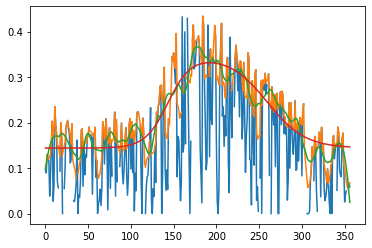

In [24]:
fig, ax = plt.subplots()
ax.plot(avhrr_sub['NDVI'].isel(longitude=1, latitude=1).squeeze().values)
ax.plot(avhrr_sub['NDVI_smth1_ds'].isel(longitude=1, latitude=1).squeeze().values)
ax.plot(avhrr_sub['NDVI_smth2'].isel(longitude=1, latitude=1).squeeze().values)
ax.plot(avhrr_sub['NDVI_smth2_dl'].isel(longitude=1, latitude=1).squeeze().values)


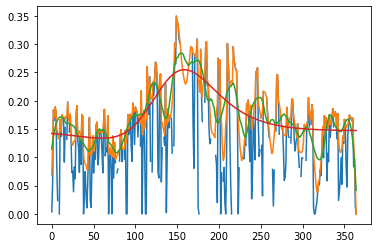

In [110]:
fig, ax = plt.subplots()
ax.plot(test.isel(longitude=1).squeeze().values)
ax.plot(test2.isel(longitude=1).squeeze().values)
ax.plot(test3.isel(longitude=1).squeeze().values)
ax.plot(test4.isel(longitude=1).squeeze().values)


In [22]:
df_ndvi_avhrr_fnl = pd.DataFrame(columns=['Date', 'ndvi', 'ndvi_smooth', 'ndvi_season_dl'])
for yr in range(2020, 2021):
    print(yr)
    # AVHRR image collection over the feature collection and cloudmask
    ndvi_avhrr = ee.ImageCollection("NOAA/CDR/AVHRR/NDVI/V5").filterBounds(fc).map(avhrrMask)
    df_ndvi_avhrr = timeSeriesData(ndvi_avhrr, setData, name='ndvi', band_name='NDVI',
                                   date_range=[str(yr) + '-01-01',
                                               str(yr) + '-12-31'])
    df_ndvi_avhrr['Date'] = pd.to_datetime(df_ndvi_avhrr['Date'])
    df_ndvi_avhrr['ndvi_smooth'] = apply_savgol(
        despike_ts(
            np.array(
                savitzky_golay_filtering(
                    df_ndvi_avhrr.index, df_ndvi_avhrr['ndvi'], wnds=[21, 13])),
            dat_thresh=1000, days_thresh=30),
        window=31, polynom=3)

    try:
        p0 = [df_ndvi_avhrr['ndvi_smooth'].quantile(q=0.01),
              np.max(df_ndvi_avhrr['ndvi_smooth']),
              int(np.percentile(df_ndvi_avhrr.index, 25)),
              1.0,
              int(np.percentile(df_ndvi_avhrr.index, 75)),
              1.0]  # this is a mandatory initial guess
        popt, pcov = curve_fit(double_logistic, df_ndvi_avhrr.index, df_ndvi_avhrr['ndvi_smooth'],
                               p0, method='lm', maxfev=20000)
        df_ndvi_avhrr['ndvi_season_dl'] = double_logistic(df_ndvi_avhrr.index, *popt)
    except RuntimeError:
        try:
            p0 = [df_ndvi_avhrr['ndvi_smooth'].quantile(q=0.01),
                  np.max(df_ndvi_avhrr['ndvi_smooth']),
                  120,
                  1.0,
                  int(np.percentile(df_ndvi_avhrr.index, 75)),
                  1.0]  # this is a mandatory initial guess
            popt, pcov = curve_fit(double_logistic, df_ndvi_avhrr.index, df_ndvi_avhrr['ndvi_smooth'],
                                   p0, method='lm', maxfev=20000)
            df_ndvi_avhrr['ndvi_season_dl'] = double_logistic(df_ndvi_avhrr.index, *popt)
        except RuntimeError:
            print(RuntimeError)

    df_ndvi_avhrr_fnl = df_ndvi_avhrr_fnl.append(df_ndvi_avhrr)



2020
0  :  3901.281785941927
1  :  3191.331193665681
2  :  3541.338152560251


In [23]:
df_ndvi_avhrr_fnl

,Date,ndvi,ndvi_smooth,ndvi_season_dl
0,2020-01-02,70.714432,66.751032,58.752216
1,2020-01-03,46.757074,67.936598,58.755841
2,2020-01-04,54.941117,68.897894,58.760295
3,2020-01-05,77.870721,69.652300,58.765763
4,2020-01-06,52.569993,70.217197,58.772477
...,...,...,...,...
354,2020-12-26,60.794252,70.800874,58.736435
355,2020-12-27,72.237107,70.513963,58.736435
356,2020-12-28,56.606464,70.107671,58.736435
357,2020-12-29,77.839242,69.577714,58.736435
